In [1]:
import pandas as pd

exclude_perc_threshold = 0.5

no_timepoint_excluded = pd.read_excel("/mnt/LABS/tbi/implicitmem_SCI/code/feat_lev1/all_03.xlsx")
run_excluded = no_timepoint_excluded.loc[no_timepoint_excluded.exclude_perc >= exclude_perc_threshold]

run_excluded = run_excluded.assign(subjectid = run_excluded['input'].apply(lambda x: x.split('_')[0]))
run_excluded = run_excluded.assign(runid = run_excluded['input'].apply(lambda x: x.split('_')[2]))
run_excluded = run_excluded.assign(featdir = run_excluded['subjectid'] + '_' + run_excluded['runid'])

run_excluded

,input,exclude_num,exclude_perc,subjectid,runid,featdir
0,sub-IPLSCI108_task-ipl_run-2_desc-confounds_ti...,215,0.922747,sub-IPLSCI108,run-2,sub-IPLSCI108_run-2
1,sub-IPLHC220_task-ipl_run-3_desc-confounds_tim...,140,0.679612,sub-IPLHC220,run-3,sub-IPLHC220_run-3
2,sub-IPLSCI108_task-ipl_run-1_desc-confounds_ti...,150,0.672646,sub-IPLSCI108,run-1,sub-IPLSCI108_run-1
3,sub-IPLHC220_task-ipl_run-2_desc-confounds_tim...,197,0.611801,sub-IPLHC220,run-2,sub-IPLHC220_run-2
4,sub-IPLHC219_task-ipl_run-3_desc-confounds_tim...,95,0.582822,sub-IPLHC219,run-3,sub-IPLHC219_run-3
5,sub-IPLSCI121_task-ipl_run-2_desc-confounds_ti...,138,0.570248,sub-IPLSCI121,run-2,sub-IPLSCI121_run-2
6,sub-IPLSCI129_task-ipl_run-1_desc-confounds_ti...,120,0.550459,sub-IPLSCI129,run-1,sub-IPLSCI129_run-1
7,sub-IPLSCI123_task-ipl_run-1_desc-confounds_ti...,159,0.550173,sub-IPLSCI123,run-1,sub-IPLSCI123_run-1
8,sub-IPLSCI123_task-ipl_run-2_desc-confounds_ti...,169,0.548701,sub-IPLSCI123,run-2,sub-IPLSCI123_run-2
9,sub-IPLHC219_task-ipl_run-2_desc-confounds_tim...,130,0.520000,sub-IPLHC219,run-2,sub-IPLHC219_run-2


In [2]:
import pandas as pd
import numpy as np
import nilearn
from nilearn.image import concat_imgs
import glob
from nilearn.decoding import FREMClassifier

In [3]:
derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '100'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = ['hc' if 'HC' in nii_name else 'sci' for nii_name in niimgs]
wholebrain = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

perf_df_wholebrain = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=wholebrain, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_wholebrain = pd.concat([perf_df_wholebrain, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14767] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14758] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [1476

In [4]:
perf_df_wholebrain

,classifier,accuracy
0,svc_l2,57.0
1,svc_l1,72.666667
2,logistic_l2,61.666667
3,logistic_l1,73.0
4,dummy_classifier,50.0


In [5]:
from nilearn import plotting
template = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

svc_l1_wholebrain = FREMClassifier(estimator='svc_l1',cv=50, mask=wholebrain, n_jobs=20, scoring='accuracy')
svc_l1_wholebrain.fit(concat_imgs(niimgs), group)

svc_l1_wholebrain.coef_img_["hc"].to_filename('HC_svc_l1_wholebrain_coeff.nii.gz')
svc_l1_wholebrain.coef_img_["sci"].to_filename('SCI_svc_l1_wholebrain_coeff.nii.gz')


/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14767] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14758] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


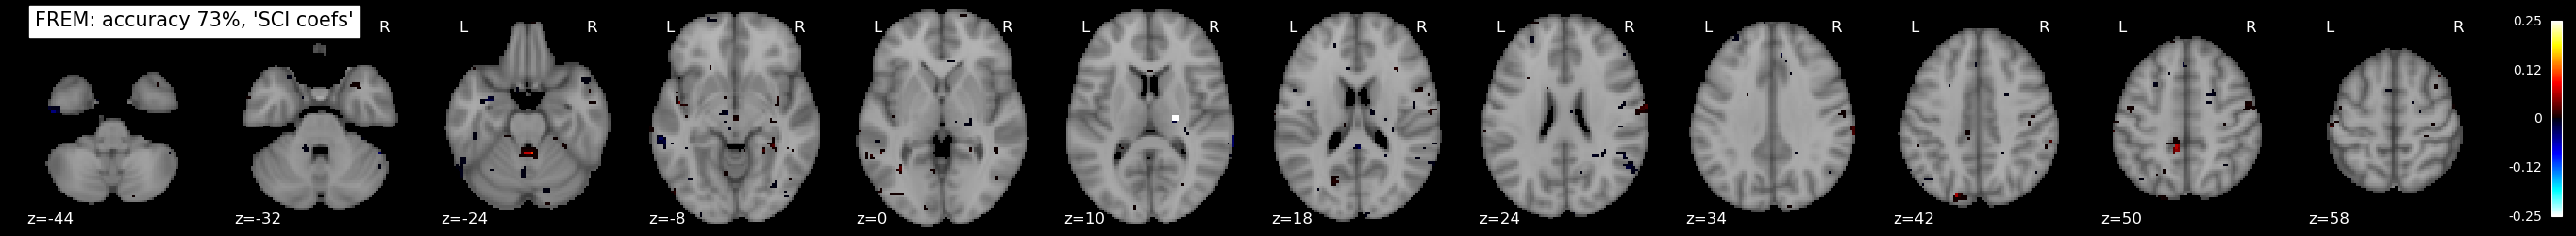

In [6]:
accuracy = np.mean(svc_l1_wholebrain.cv_scores_['sci']) * 100
plotting.plot_stat_map(svc_l1_wholebrain.coef_img_["sci"], bg_img=nilearn.image.load_img(template),
                       title="FREM: accuracy %g%%, 'SCI coefs'" % accuracy,
                       display_mode="z", cut_coords=12)
plotting.show()

In [7]:
log_l1_wholebrain = FREMClassifier(estimator='logistic_l1',cv=50, mask=wholebrain, n_jobs=20, scoring='accuracy')
log_l1_wholebrain.fit(concat_imgs(niimgs), group)

log_l1_wholebrain.coef_img_["hc"].to_filename('HC_log_l1_wholebrain_coeff.nii.gz')
log_l1_wholebrain.coef_img_["sci"].to_filename('SCI_log_l1_wholebrain_coeff.nii.gz')


/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14767] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14758] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


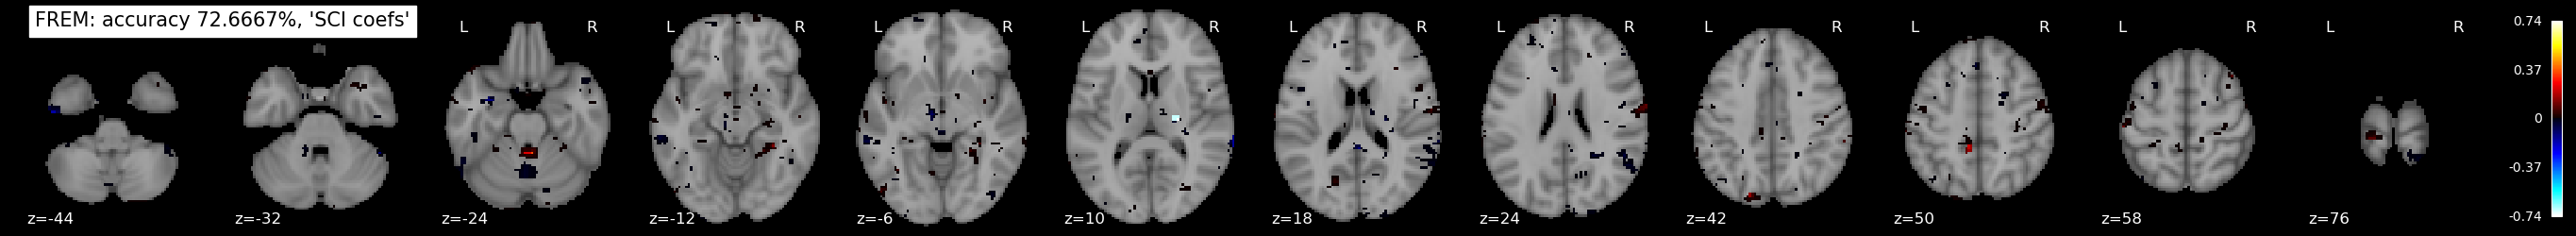

In [8]:
accuracy = np.mean(log_l1_wholebrain.cv_scores_['sci']) * 100
plotting.plot_stat_map(log_l1_wholebrain.coef_img_["sci"], bg_img=nilearn.image.load_img(template),
                       title="FREM: accuracy %g%%, 'SCI coefs'" % accuracy,
                       display_mode="z", cut_coords=12)
plotting.show()

# HP 150

In [9]:
derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '150'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = ['hc' if 'HC' in nii_name else 'sci' for nii_name in niimgs]
wholebrain = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

perf_df_150 = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=wholebrain, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_150 = pd.concat([perf_df_150, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [14762] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [13908 14785] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: inva

# Diff between hp100 and hp150

Pretty much the same for FSL FLAME whole-brain group test, but for MVPA, HP 150 resulted in slightly better model performance for SVC

In [10]:
perf_df_150

,classifier,accuracy
0,svc_l2,60.333333
1,svc_l1,74.666667
2,logistic_l2,65.333333
3,logistic_l1,73.0
4,dummy_classifier,50.0


In [11]:
perf_df_wholebrain

,classifier,accuracy
0,svc_l2,57.0
1,svc_l1,72.666667
2,logistic_l2,61.666667
3,logistic_l1,73.0
4,dummy_classifier,50.0


# Run 2 HP 100

In [12]:
derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '100'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = ['hc' if 'HC' in nii_name else 'sci' for nii_name in niimgs]
wholebrain = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
basalganglia = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/striatum.nii.gz'
m1 = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/m1.nii.gz'
sml = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/sml.nii.gz' # BG, thalamus, M1, S1, SMA

In [13]:
perf_df_basalganglia = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=basalganglia, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_basalganglia = pd.concat([perf_df_basalganglia, new_row.to_frame().T], ignore_index=True)

In [14]:
perf_df_basalganglia

,classifier,accuracy
0,svc_l2,62.333333
1,svc_l1,68.0
2,logistic_l2,68.333333
3,logistic_l1,67.333333
4,dummy_classifier,50.0


In [15]:
perf_df_m1 = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=m1, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_m1 = pd.concat([perf_df_m1, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),


In [16]:
perf_df_m1

,classifier,accuracy
0,svc_l2,48.333333
1,svc_l1,56.666667
2,logistic_l2,49.333333
3,logistic_l1,56.666667
4,dummy_classifier,50.0


In [17]:
perf_df_sml = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=sml, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_sml = pd.concat([perf_df_sml, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),


In [18]:
perf_df_sml

,classifier,accuracy
0,svc_l2,66.666667
1,svc_l1,66.333333
2,logistic_l2,70.0
3,logistic_l1,67.333333
4,dummy_classifier,50.0


In [19]:
derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '100'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = ['hc' if 'HC' in nii_name else 'sci' for nii_name in niimgs]
wholebrain = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
basalganglia = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/striatum.nii.gz'
m1 = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/m1.nii.gz'
sml = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/sml.nii.gz' # BG, thalamus, M1, S1, SMA


from nilearn import plotting
template = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz'

log_l2_slm = FREMClassifier(estimator='logistic_l2',cv=50, mask=sml, n_jobs=20, scoring='accuracy')
log_l2_slm.fit(concat_imgs(niimgs), group)
accuracy = np.mean(log_l2_slm.cv_scores_['sci']) * 100

log_l2_slm.coef_img_["hc"].to_filename('HC_log_l2_slm_coeff.nii.gz')
log_l2_slm.coef_img_["sci"].to_filename('SCI_log_l2_slm_coeff.nii.gz')


/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

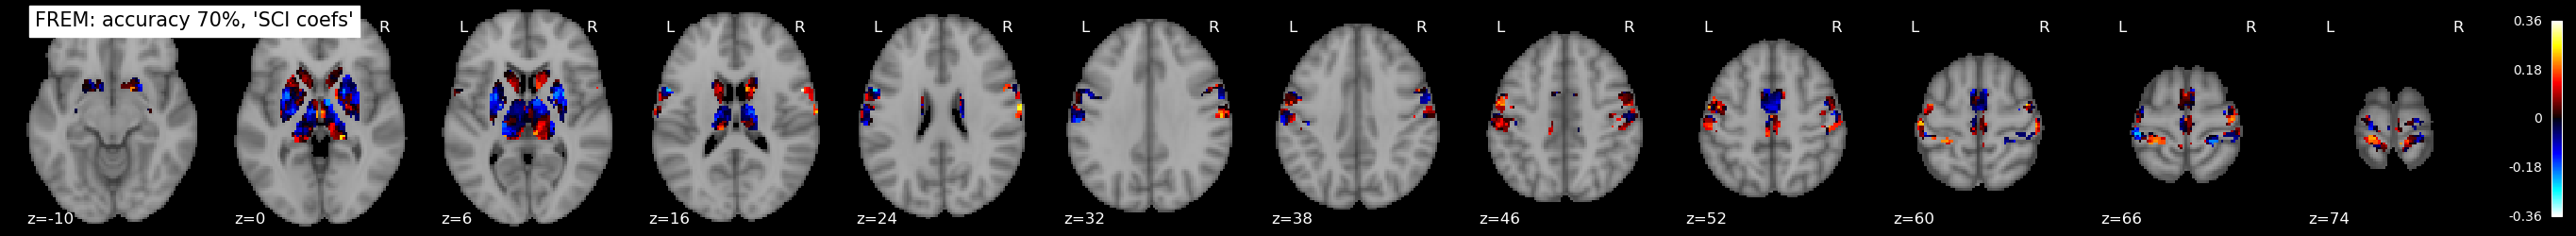

In [20]:
plotting.plot_stat_map(log_l2_slm.coef_img_["sci"], bg_img=nilearn.image.load_img(template),
                       title="FREM: accuracy %g%%, 'SCI coefs'" % accuracy,
                       display_mode="z", cut_coords=12)
plotting.show()

# Run 2 HP 150

In [21]:
derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '150'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = ['hc' if 'HC' in nii_name else 'sci' for nii_name in niimgs]
wholebrain = '/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'
basalganglia = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/striatum.nii.gz'
m1 = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/m1.nii.gz'
sml = '/mnt/LABS/tbi/sequenceLearning_TBI_NJCBIR/code/create_roi/sml.nii.gz' # BG, thalamus, M1, S1, SMA

In [22]:
perf_df_basalganglia_150 = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=basalganglia, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_basalganglia_150 = pd.concat([perf_df_basalganglia_150, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
perf_df_basalganglia_150

,classifier,accuracy
0,svc_l2,63.0
1,svc_l1,69.333333
2,logistic_l2,65.0
3,logistic_l1,69.0
4,dummy_classifier,50.0


In [24]:
perf_df_m1_150 = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=m1, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_m1_150 = pd.concat([perf_df_m1_150, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

In [25]:
perf_df_m1_150

,classifier,accuracy
0,svc_l2,47.333333
1,svc_l1,55.333333
2,logistic_l2,51.333333
3,logistic_l1,53.333333
4,dummy_classifier,50.0


In [26]:
perf_df_sml_150 = pd.DataFrame({'classifier': [], 'accuracy': []})
for clf in ['svc_l2', 'svc_l1', 'logistic_l2', 'logistic_l1', 'dummy_classifier']:
    decoder = FREMClassifier(estimator=clf,cv=50, mask=sml, n_jobs=20, scoring='accuracy')
    decoder.fit(concat_imgs(niimgs), group)
    accuracy = np.mean(decoder.cv_scores_['hc']) * 100
    new_row = pd.Series({'classifier': clf, 'accuracy': accuracy})
    perf_df_sml_150 = pd.concat([perf_df_sml_150, new_row.to_frame().T], ignore_index=True)

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1. / max_connectivity, 0),
/home/ttong/.conda/envs/tienenv/lib/python3.10/site-packages/nilearn/regions/rena_clustering.py:204: RuntimeWarning: divide by zero encountered in divide
  inv_max = dia_matrix((1.

In [27]:
perf_df_sml_150

,classifier,accuracy
0,svc_l2,65.0
1,svc_l1,65.333333
2,logistic_l2,66.666667
3,logistic_l1,65.333333
4,dummy_classifier,50.0
